In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *

(3, 2)


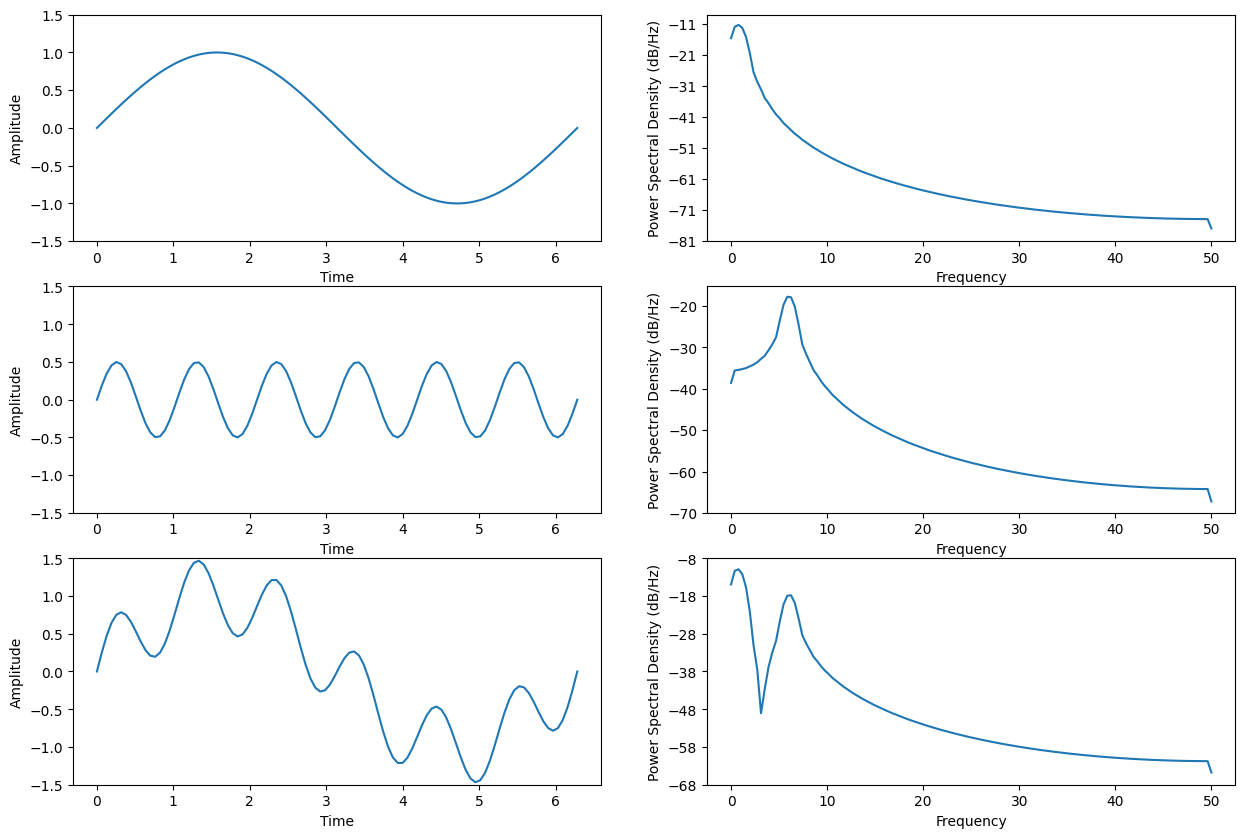

In [2]:
# make a sine wave
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

# make second sine wave with different frequency and lower amplitude
y2 = 0.5 * np.sin(6*x)    

# plot it on two subplots
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
print(ax.shape)
ax[0,0].plot(x, y)
# set y axis limits and name
ax[0,0].set_ylim(-1.5, 1.5)
ax[0,0].set_ylabel('Amplitude')
ax[0,0].set_xlabel('Time') 

ax[1,0].plot(x, y2)
ax[1,0].set_ylim(-1.5, 1.5)
ax[1,0].set_ylabel('Amplitude')
ax[1,0].set_xlabel('Time') 

# add them together
y3 = y + y2
ax[2,0].set_ylim(-1.5, 1.5)
ax[2,0].set_ylabel('Amplitude')
ax[2,0].set_xlabel('Time') 

ax[2,0].plot(x, y3)

# plot power spectrum density
ax[0,1].psd(y, Fs=100)
# remove grid lines
ax[0,1].grid(False)
ax[1,1].psd(y2, Fs=100)
ax[1,1].grid(False)
ax[2,1].psd(y3, Fs=100)
ax[2,1].grid(False)

plt.show()


In [3]:
# read the data
data = 'data/w12_18_spont/lfp100.ibw'

# load the data
data_1st_probe = load_data(data)

# get the sampling rate
fs = data_1st_probe.sampling_rate

# get the time series
ts_1st_probe = np.squeeze(data_1st_probe.magnitude)[:80000]
times = data_1st_probe.times.magnitude[:80000]
ts_1st_probe = filter_line_noise(ts_1st_probe, fs, 400)

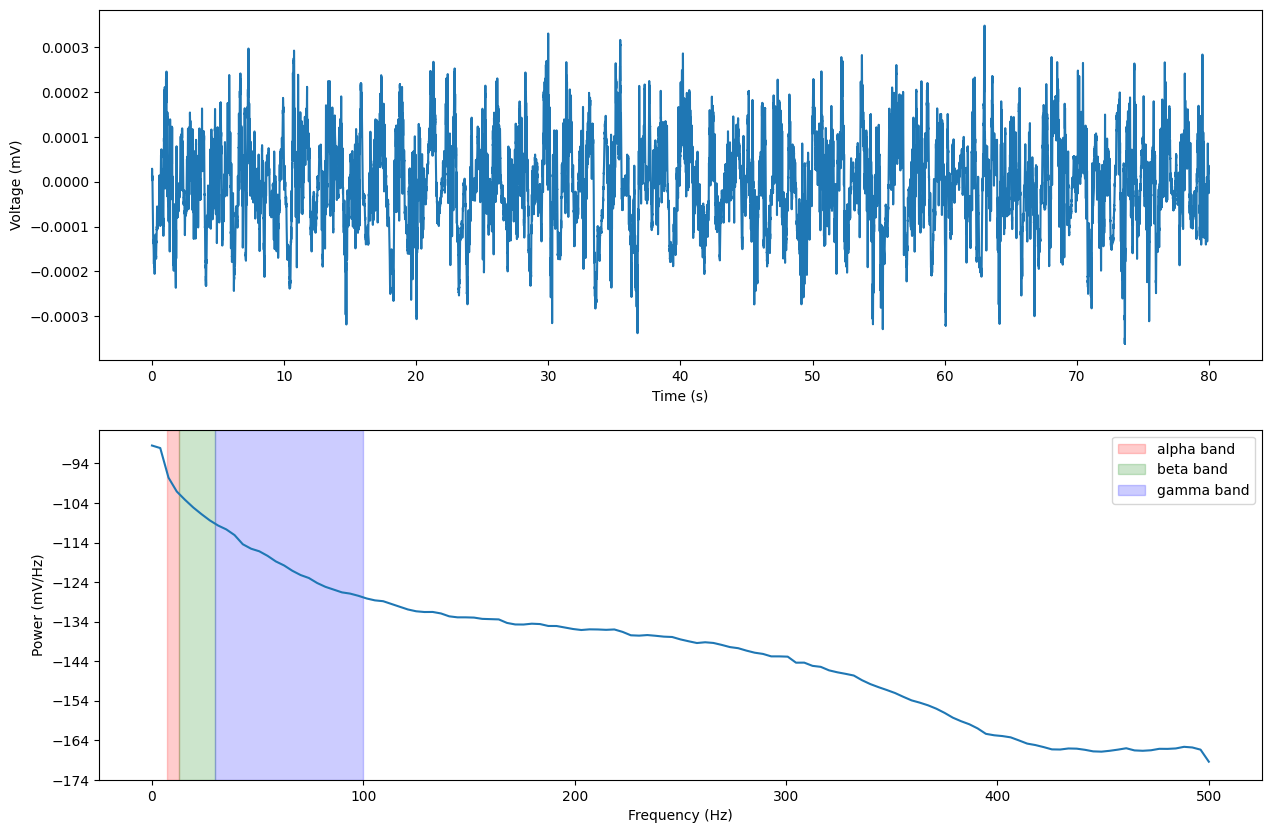

In [4]:
# plot the time series
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(times, ts_1st_probe)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Voltage (mV)')

# plot the power spectrum density
ax[1].psd(ts_1st_probe, Fs=1000)
ax[1].grid(False)
# set y axis to log scale
# ax[1].set_yscale('log')

ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Power (mV/Hz)')
# color the power spectrum density values between 7 and 13 Hz and add a label "alpha band"
ax[1].axvspan(7, 13, alpha=0.2, color='red', label='alpha band')
# color the power spectrum density values between 13 and 30 Hz and add a label "beta band"
ax[1].axvspan(13, 30, alpha=0.2, color='green', label='beta band')
# color the power spectrum density values between 30 and 100 Hz and add a label "gamma band"
ax[1].axvspan(30, 100, alpha=0.2, color='blue', label='gamma band')
# ax[1].set_xlim(0,150)
ax[1].legend()

plt.show()

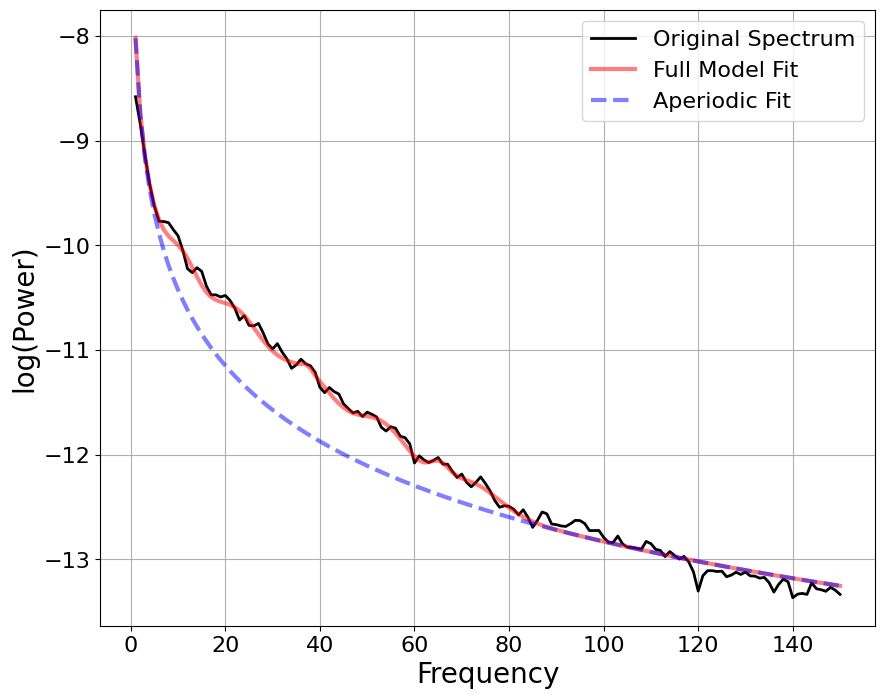

In [5]:
from fooof import FOOOF
from neurodsp.spectral import compute_spectrum_welch
from fooof.plts.fm import plot_fm

# take only times in the interval 1202 and 1205
freqs, powers = compute_spectrum_welch(ts_1st_probe, fs=1000)
# fit fooof model
fm = FOOOF(verbose=False)
fm.fit(freqs, powers, freq_range=[0,150])
# plot the periodic component
plot_fm(fm, plot_peaks=None, plot_aperiodic=True, plt_log=False, add_legend=True)

In [6]:
# import
from glob import glob
from utils import *
import matplotlib.pyplot as plt
import numpy as np
from neurodsp.spectral import compute_spectrum_welch
from fooof import FOOOF

In [7]:
# read 20 kHz data
from tqdm import tqdm
# read the 20 khz data, filter it and detect spikes
ids = 97
# ids = range(65,81)
# if any id is present in the data, read it and filter it
filename = 'data/w12_18_nlx_2021_11_12(20khz sampl_rate_spontan)/csc98_lfp_0001.ncs'
spike_train, hsr_signal = read_spikes(filename)

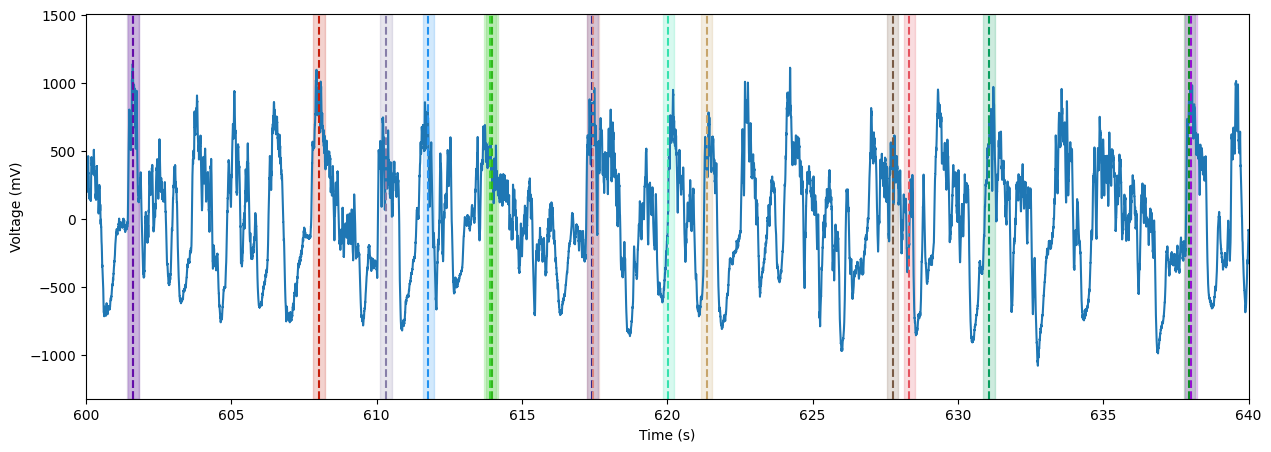

In [17]:
from viziphant.rasterplot import rasterplot, eventplot
interval = [600,640]

# set figure size
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(hsr_signal[0], hsr_signal[1])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')

# get spikes in the interval
spikes_in_interval = spike_train[(spike_train > interval[0]) & (spike_train < interval[1])]
# add dashed lines at times of spikes
colors = []
for spike in spikes_in_interval:
    # set random color
    color = np.random.rand(3,)
    colors.append(color)
    plt.axvline(spike, color=color, linestyle='--')
    # visualize 200 ms before and after the spike time as a shaded area
    plt.axvspan(spike.magnitude-0.2, spike.magnitude+0.2, alpha=0.2, color=color)



# set x axis limits
plt.xlim(interval[0], interval[1])
# ax[1].set_xlim(interval)
plt.show()

601.6089
601.6329
608.0067
610.331
611.7838
613.9018
613.9766
617.4267
617.45085
620.03655
621.35365
627.75065
628.33405
631.07615
637.96745
638.01835


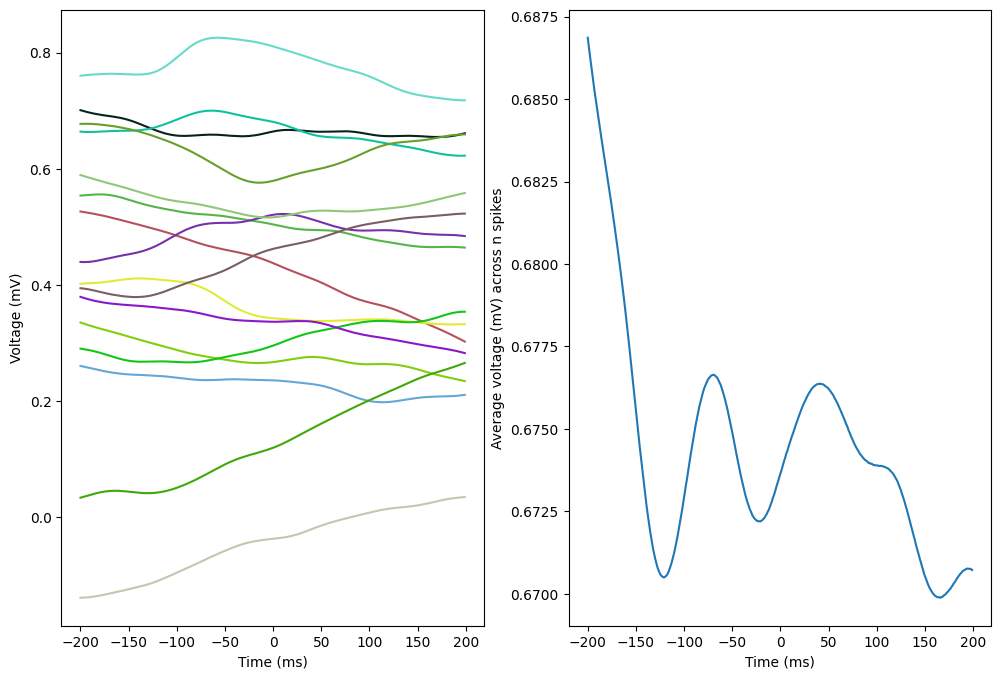

In [15]:
# plot LFP signal only in the 100 ms window around spike time
# set figure size
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
# normalise the signal
signal = hsr_signal[1] / np.max(hsr_signal[1])
wind_size = 200
average = np.zeros(wind_size * 2)
for spike, color in zip(spikes_in_interval, colors):
    # # get the spike time
    spike_time = spike.magnitude
    print(spike_time)
    # get the index of the spike time
    spike_index = np.where(hsr_signal[0] == spike_time)[0][0]
    # get the 100 ms window around the spike time
    window = signal[spike_index-wind_size:spike_index+wind_size]
    average += window
    # plot the LFP signal
    time_interval = np.arange(-wind_size, wind_size)
    ax[0].plot(time_interval, window, label='LFP signal at {}'.format(spike_time), color=color)
    # set y axis title
    ax[0].set_ylabel('Voltage (mV)')
    # set x axis title
    ax[0].set_xlabel('Time (ms)')
    # ax[0].legend()

# on the second axis plot the average LFP signal
# get the average LFP signal
# plot the average LFP signal
ax[1].plot(time_interval, average/10, label='Average LFP signal')
# set y axis title
ax[1].set_ylabel('Average voltage (mV) across n spikes')
# set x axis title
ax[1].set_xlabel('Time (ms)')

plt.show()

In [105]:
len(hsr_signal[1])

31350463